In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

c:\Users\debon\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.ToTensor()

traindataset = datasets.FashionMNIST('./downloads/', download=True, train=True, transform=transform)
testdataset = datasets.FashionMNIST('./downloads/', download=True, train=False, transform=transform)

In [3]:
bs =1000
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=bs, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=bs, shuffle=False, num_workers=4)

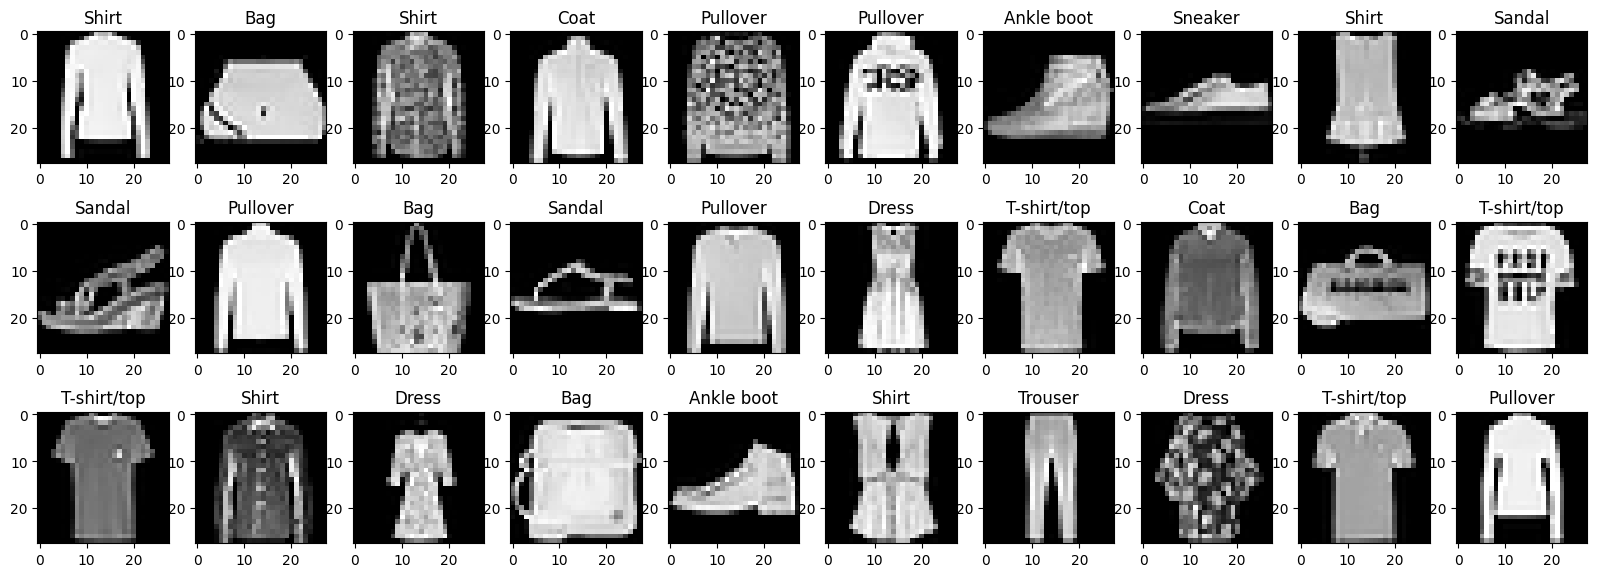

In [4]:
def view_samples():
    
    test_images, labels = next(iter(testloader))

    fig = plt.figure(figsize =(20,7))
    nrows = 3
    ncols = 10
    b=np.random.randint(0,test_images.shape[0]-nrows*ncols)
    for i in range(nrows*ncols):
        inp = test_images.view(-1, 28, 28)
        plot = fig.add_subplot(nrows, ncols, i+1)
        plot.set_title(testdataset.classes[labels[i+b].cpu().numpy()])
        imgplot = plt.imshow(inp[i+b].cpu(), cmap='gray')
    plt.show()
view_samples()

In [5]:

class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        )
    self.decoder = nn.Sequential(
        nn.Linear(64, 128),
        nn.Sigmoid(),
        nn.Linear(128, 256),
        nn.Sigmoid(),
        nn.Linear(256, 512),
        nn.Sigmoid(),
        nn.Linear(512, 784),
        nn.Sigmoid()
        )
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x
     

In [6]:

model = AutoEncoder()

In [7]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [8]:
optimizer =  torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [9]:
epochs = 60
noise_factor =0.2
loss_list = []
for epoch in range(epochs):
  train_loss = 0.0
  val_loss = 0.0
  
  for images, labels in trainloader:
    ## add random noise to the input images
    noisy_imgs = images + noise_factor * torch.randn(*images.shape)
    # Clip the images to be between 0 and 1
    noisy_imgs = np.clip(noisy_imgs, 0., 1.)
            
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    ## forward pass: compute predicted outputs by passing *noisy* images to the model
    outputs = model(noisy_imgs.view(-1,784))
    # calculate the loss
    # the "target" is still the original, not-noisy images
    loss = criterion(outputs, images.view(-1,784))
    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optimizer.step()
    # update running training loss
    train_loss += loss.item()*images.size(0)
  with torch.no_grad():
    for images, labels in testloader:
      ## add random noise to the input images
      noisy_imgs = images + noise_factor * torch.randn(*images.shape)
      # Clip the images to be between 0 and 1
      noisy_imgs = np.clip(noisy_imgs, 0., 1.)
      
      ## forward pass: compute predicted outputs by passing *noisy* images to the model
      outputs = model(noisy_imgs.view(-1,784))
      # calculate the loss
      # the "target" is still the original, not-noisy images
      loss = criterion(outputs, images.view(-1,784))
      # update running training loss
      val_loss += loss.item()*images.size(0)

  # print avg training statistics 
  train_loss = train_loss/len(trainloader)
  val_loss = val_loss/len(testloader)
  print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f}, \tTest Loss: {val_loss:.6f}, ')
  loss_list.append([train_loss,val_loss])
loss_list = np.array(loss_list)

Epoch: 1 	Training Loss: 91.975056, 	Test Loss: 82.842854, 
Epoch: 2 	Training Loss: 68.943090, 	Test Loss: 62.959310, 
Epoch: 3 	Training Loss: 62.156324, 	Test Loss: 60.249420, 
Epoch: 4 	Training Loss: 58.624256, 	Test Loss: 54.825578, 
Epoch: 5 	Training Loss: 48.642352, 	Test Loss: 43.212281, 
Epoch: 6 	Training Loss: 41.208795, 	Test Loss: 39.014455, 
Epoch: 7 	Training Loss: 38.674966, 	Test Loss: 37.147480, 
Epoch: 8 	Training Loss: 36.817689, 	Test Loss: 36.235776, 
Epoch: 9 	Training Loss: 35.891755, 	Test Loss: 35.206963, 
Epoch: 10 	Training Loss: 35.194798, 	Test Loss: 34.518402, 
Epoch: 11 	Training Loss: 34.394654, 	Test Loss: 33.873433, 
Epoch: 12 	Training Loss: 33.766190, 	Test Loss: 33.367104, 
Epoch: 13 	Training Loss: 33.092463, 	Test Loss: 32.405521, 
Epoch: 14 	Training Loss: 31.979144, 	Test Loss: 31.360024, 
Epoch: 15 	Training Loss: 31.003670, 	Test Loss: 30.472603, 
Epoch: 16 	Training Loss: 30.053826, 	Test Loss: 29.485594, 
Epoch: 17 	Training Loss: 29.0574

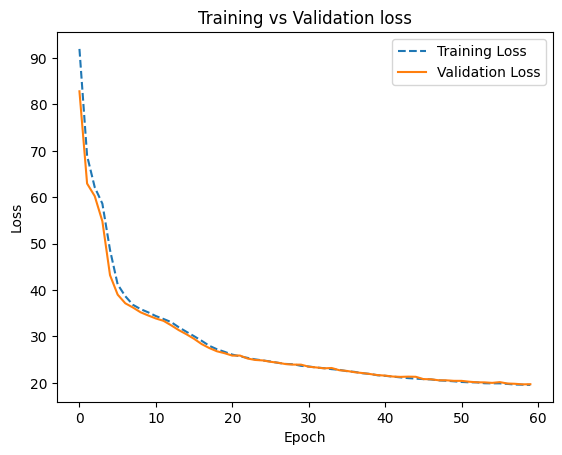

In [10]:
plt.title("Training vs Validation loss")
plt.plot(loss_list[:,0], linestyle='--', label="Training Loss")
plt.plot(loss_list[:,1], linestyle='-', label="Validation Loss" )
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [11]:
test_images, test_labels = next(iter(testloader))

noisy_test_imgs = np.clip(test_images + noise_factor * torch.randn(*test_images.shape), 0., 1.)

test_output = model(noisy_test_imgs.view(-1,784))


### Some original,noise imposed and reconstructed images from above DAE 

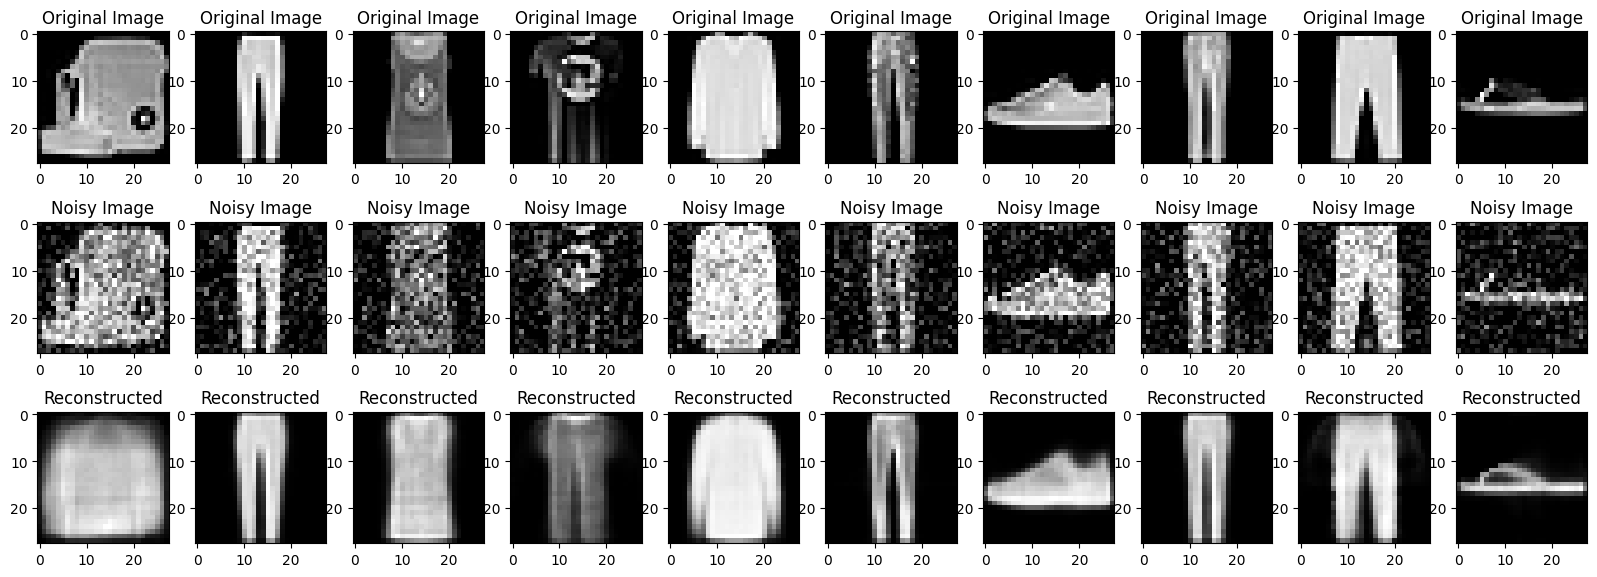

In [12]:

fig = plt.figure(figsize =(20,7))
nrows = 10
b=np.random.randint(0,test_images.shape[0]-nrows)
for i in range(nrows):
    plot = fig.add_subplot( 3,nrows, 0*nrows+i+1)
    plot.set_title('Original Image')
    imgplot = plt.imshow(test_images.view(-1, 28, 28)[b+i].cpu().detach(), cmap='gray')

    plot = fig.add_subplot( 3,nrows,  1*nrows+i+1)
    plot.set_title('Noisy Image')
    imgplot = plt.imshow(noisy_test_imgs.view(-1, 28, 28)[b+i].cpu().detach(), cmap='gray')

    plot = fig.add_subplot( 3,nrows,  2*nrows+i+1)
    plot.set_title('Reconstructed')
    imgplot = plt.imshow(test_output.view(-1, 28, 28)[b+i].cpu().detach(), cmap='gray')

plt.show()

In [13]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn.manifold import TSNE

## Function to Scale and visualize the embedding vectors
def plot_embedding(X_embed,y, title=None):
    with torch.no_grad():
        X = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=40).fit_transform(X_embed)
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)     
    plt.figure(figsize=(12,10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    if hasattr(offsetbox, 'AnnotationBbox'):
        ## only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 20e-3:
                ## don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(test_images[i].reshape(28,28), cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [14]:
test_embed = model.encoder(test_images.view(-1,784))

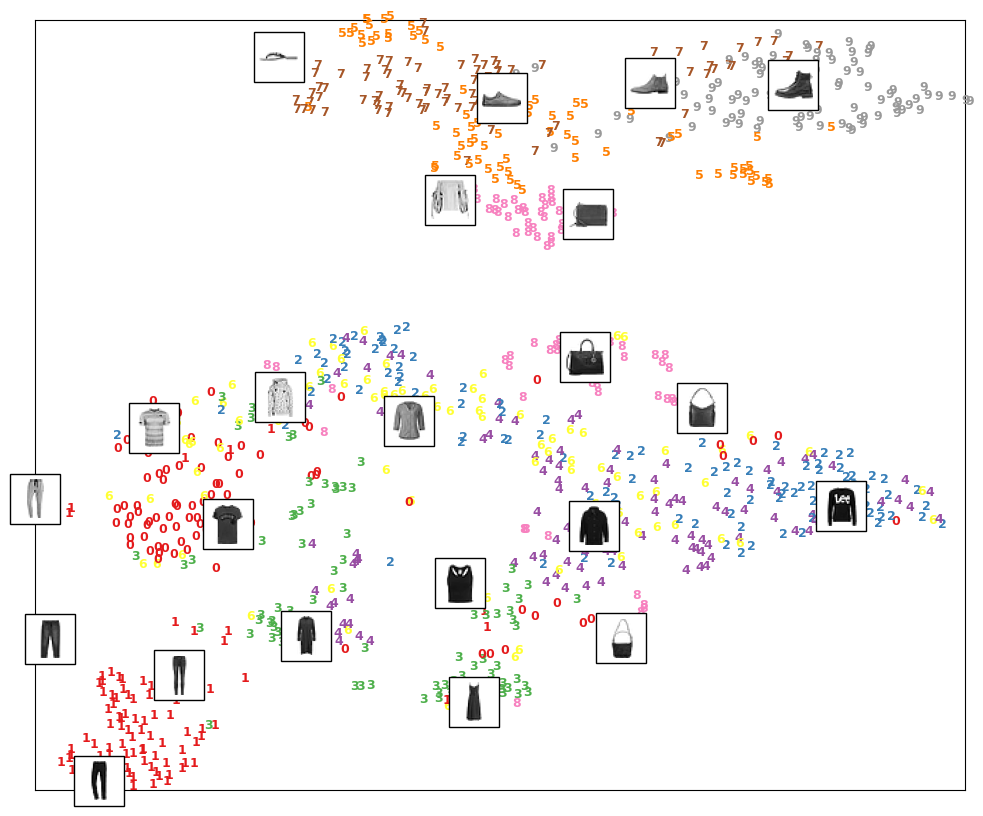

In [15]:

with torch.no_grad():
    plot_embedding(test_embed,test_labels.numpy())

###  1 FC layer with sigmoid activation for 10 class classification 

##### Roll = M21AIE225
##### X = 4, as last digit of roll no. is odd
##### Y = sigmoid, as last digit of roll no. is odd

In [17]:
class SingleFCLayerClassifier(nn.Module):
  def __init__(self):
    super(SingleFCLayerClassifier, self).__init__()
    self.encoder = model.encoder

    self.fc_layer = nn.Sequential(
        nn.Linear(64, 10),
        nn.Sigmoid()
        )
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.fc_layer(x)
    return x
     

In [18]:
classifier_1fc = SingleFCLayerClassifier()
print(classifier_1fc)

SingleFCLayerClassifier(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): Sigmoid()
  )
)


In [19]:
optimizer_1fc =  torch.optim.Adam(classifier_1fc.parameters(), lr=0.001)
criterion_1fc = nn.CrossEntropyLoss()

In [20]:
epochs = 20

loss_list = []
for epoch in range(epochs):
  train_loss = 0.0
  val_loss = 0.0
  
  for images, labels in trainloader:
            
    # clear the gradients of all optimized variables
    optimizer_1fc.zero_grad()
    ## forward pass: compute predicted outputs by passing *noisy* images to the model
    outputs = classifier_1fc(images.view(-1,784))
    # calculate the loss
    # the "target" is still the original, not-noisy images
    loss = criterion_1fc(outputs, labels)
    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optimizer_1fc.step()
    # update running training loss
    train_loss += loss.item()*images.size(0)
  with torch.no_grad():
    for images, labels in testloader:
      
      ## forward pass: compute predicted outputs by passing *noisy* images to the model
      outputs = classifier_1fc(images.view(-1,784))
      # calculate the loss
      # the "target" is still the original, not-noisy images
      loss = criterion_1fc(outputs, labels)
      # update running training loss
      val_loss += loss.item()*images.size(0)
  # print avg training statistics 
  train_loss = train_loss/len(trainloader)
  val_loss = val_loss/len(testloader)
  print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f}, \tTest Loss: {val_loss:.6f}, ')
  loss_list.append([train_loss,val_loss])
loss_list = np.array(loss_list)

Epoch: 1 	Training Loss: 1831.925221, 	Test Loss: 1699.192512, 
Epoch: 2 	Training Loss: 1621.001279, 	Test Loss: 1608.523428, 
Epoch: 3 	Training Loss: 1592.317043, 	Test Loss: 1594.775331, 
Epoch: 4 	Training Loss: 1584.206363, 	Test Loss: 1587.988126, 
Epoch: 5 	Training Loss: 1576.609896, 	Test Loss: 1583.387077, 
Epoch: 6 	Training Loss: 1568.338364, 	Test Loss: 1580.747533, 
Epoch: 7 	Training Loss: 1561.974335, 	Test Loss: 1571.308303, 
Epoch: 8 	Training Loss: 1555.370859, 	Test Loss: 1563.642192, 
Epoch: 9 	Training Loss: 1546.438028, 	Test Loss: 1555.888164, 
Epoch: 10 	Training Loss: 1542.299374, 	Test Loss: 1557.226205, 
Epoch: 11 	Training Loss: 1540.681104, 	Test Loss: 1553.661418, 
Epoch: 12 	Training Loss: 1538.271920, 	Test Loss: 1553.395057, 
Epoch: 13 	Training Loss: 1535.560292, 	Test Loss: 1549.980533, 
Epoch: 14 	Training Loss: 1533.020373, 	Test Loss: 1553.668308, 
Epoch: 15 	Training Loss: 1531.356210, 	Test Loss: 1549.279451, 
Epoch: 16 	Training Loss: 1530.255

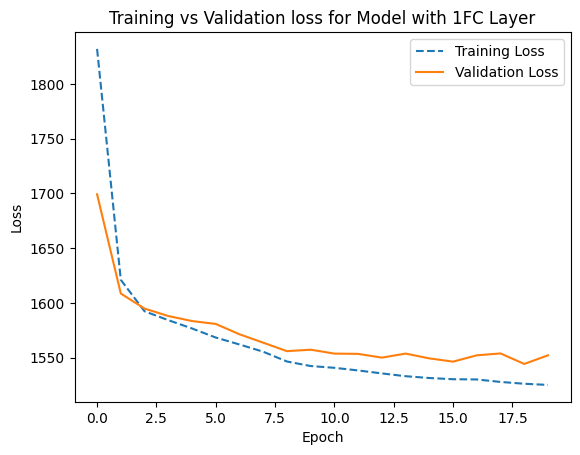

In [21]:
plt.title("Training vs Validation loss for Model with 1FC Layer")
plt.plot(loss_list[:,0], linestyle='--', label="Training Loss")
plt.plot(loss_list[:,1], linestyle='-', label="Validation Loss" )
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
test_output_1fc = classifier_1fc(test_images.view(-1,784))

In [23]:
from sklearn import metrics
import seaborn as sns
#sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})

def confusionMatrixAndAccuracyReport(Y_test, Y_pred, label):
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = np.trace(cm)/sum(cm.flatten())

    classwiseAccuracy = cm.diagonal()/cm.sum(axis=1)

    plt.figure(figsize=(10, 10))
    plt.title('Accuracy Score: {0:3.3f}'.format(overallAccuracy), size=14)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues', fmt='g')

    plt.show()
    print('Overall Accuracy Score: {0:3.3f}'.format(overallAccuracy))
    print('Classwise Accuracy Score: {0}'.format(classwiseAccuracy))

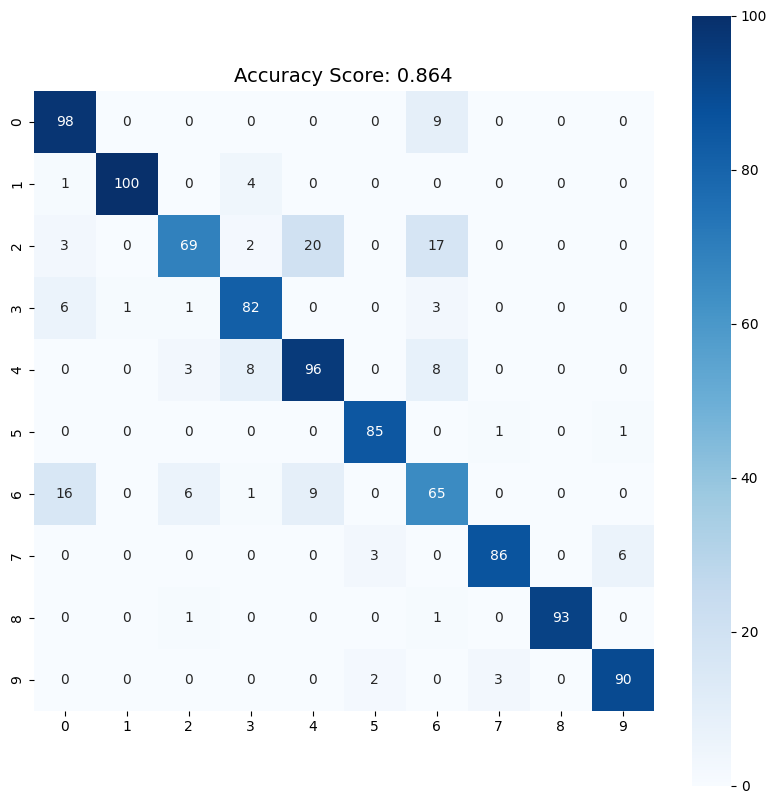

Overall Accuracy Score: 0.864
Classwise Accuracy Score: [0.91588785 0.95238095 0.62162162 0.88172043 0.83478261 0.97701149
 0.67010309 0.90526316 0.97894737 0.94736842]


In [24]:
with torch.no_grad():
    confusionMatrixAndAccuracyReport(test_labels,test_output_1fc.argmax(axis=1),testdataset.classes)

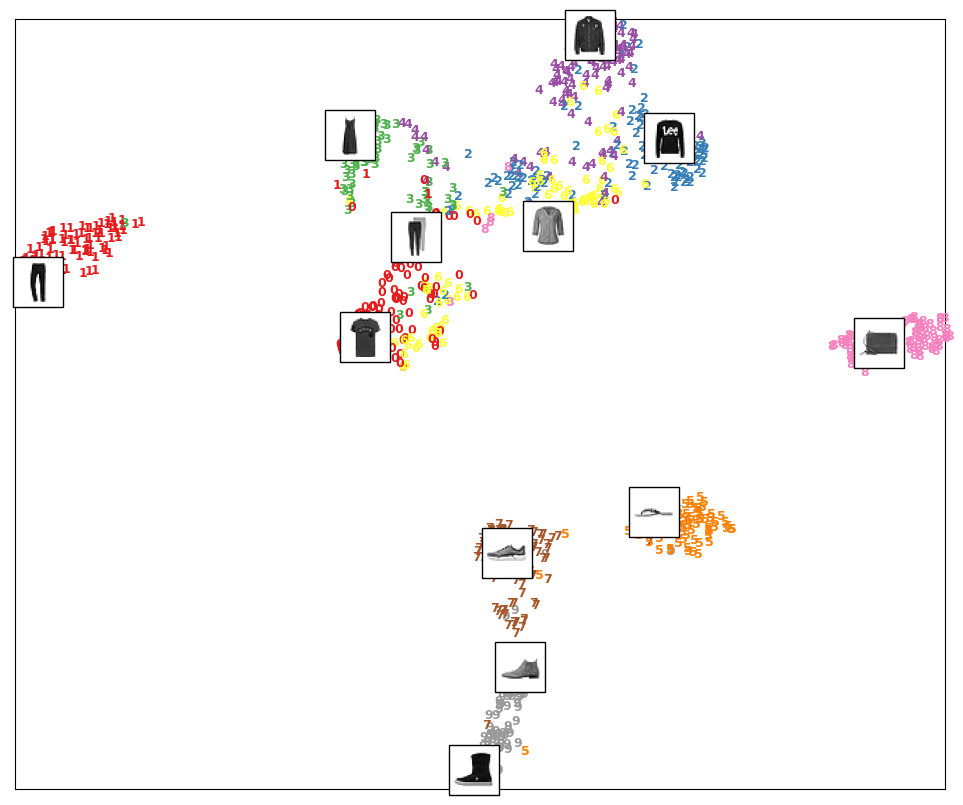

In [25]:
test_embed = model.encoder(test_images.view(-1,784))
with torch.no_grad():
    plot_embedding(test_embed,test_labels.numpy())

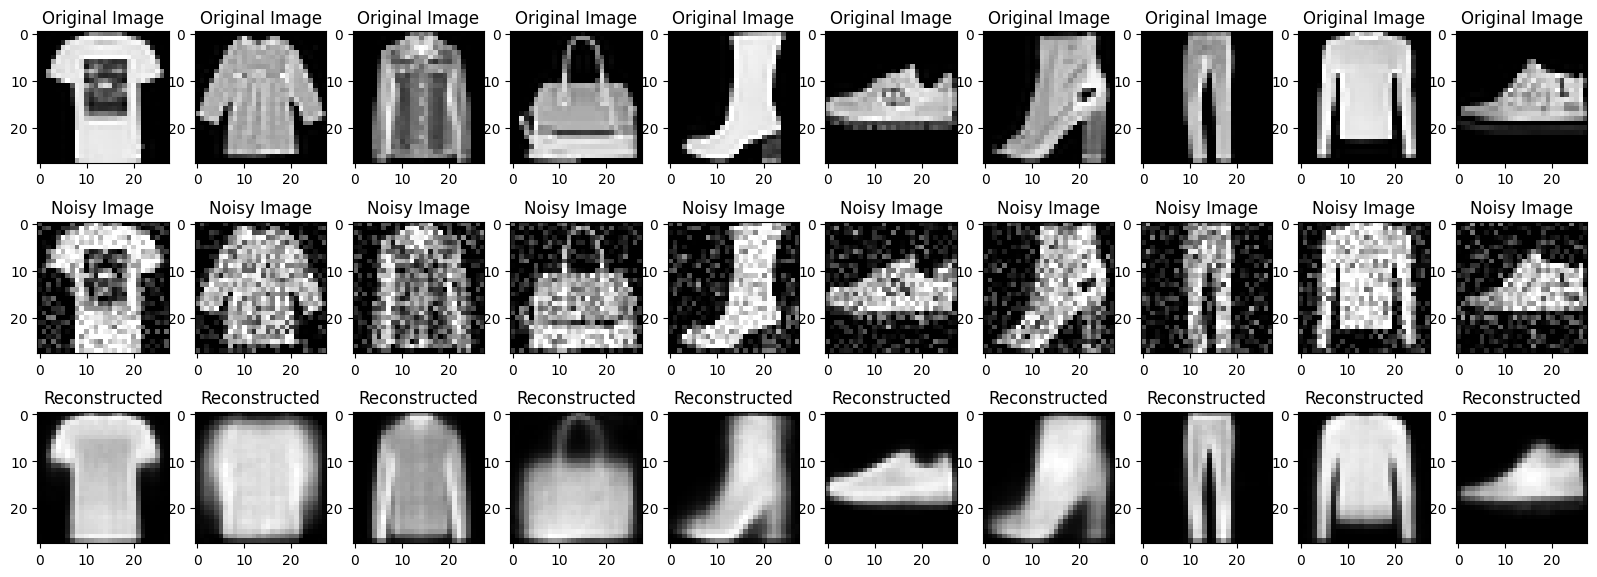

In [26]:
fig = plt.figure(figsize =(20,7))
nrows = 10
b=np.random.randint(0,test_images.shape[0]-nrows)
for i in range(nrows):
    plot = fig.add_subplot( 3,nrows, 0*nrows+i+1)
    plot.set_title('Original Image')
    imgplot = plt.imshow(test_images.view(-1, 28, 28)[b+i].cpu().detach(), cmap='gray')

    plot = fig.add_subplot( 3,nrows,  1*nrows+i+1)
    plot.set_title('Noisy Image')
    imgplot = plt.imshow(noisy_test_imgs.view(-1, 28, 28)[b+i].cpu().detach(), cmap='gray')

    plot = fig.add_subplot( 3,nrows,  2*nrows+i+1)
    plot.set_title('Reconstructed')
    imgplot = plt.imshow(test_output.view(-1, 28, 28)[b+i].cpu().detach(), cmap='gray')

plt.show()

In [27]:
class ThreeFCLayerClassifier(nn.Module):
  def __init__(self):
    super(ThreeFCLayerClassifier, self).__init__()
    self.encoder = model.encoder

    self.fc_layer = nn.Sequential(
        nn.Linear(64, 32),
        nn.Sigmoid(),
        nn.Linear(32, 16),
        nn.Sigmoid(),
        nn.Linear(16, 10),
        nn.Sigmoid(),
        )
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.fc_layer(x)
    return x
     

In [28]:
classifier_3fc = ThreeFCLayerClassifier()
print(classifier_3fc)

ThreeFCLayerClassifier(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=16, out_features=10, bias=True)
    (5): Sigmoid()
  )
)


In [29]:
optimizer_3fc =  torch.optim.Adam(classifier_3fc.parameters(), lr=0.001)
criterion_3fc = nn.CrossEntropyLoss()

In [30]:
epochs = 20
loss_list = []

for epoch in range(epochs):
  train_loss = 0.0
  val_loss = 0.0
  
  for images, labels in trainloader:
            
    # clear the gradients of all optimized variables
    optimizer_3fc.zero_grad()
    ## forward pass: compute predicted outputs by passing *noisy* images to the model
    outputs = classifier_3fc(images.view(-1,784))
    # calculate the loss
    # the "target" is still the original, not-noisy images
    loss = criterion_3fc(outputs, labels)
    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optimizer_3fc.step()
    # update running training loss
    train_loss += loss.item()*images.size(0)
  with torch.no_grad():
    for images, labels in testloader:
      
      ## forward pass: compute predicted outputs by passing *noisy* images to the model
      outputs = classifier_3fc(images.view(-1,784))
      # calculate the loss
      # the "target" is still the original, not-noisy images
      loss = criterion_3fc(outputs, labels)
      # update running training loss
      val_loss += loss.item()*images.size(0)
  # print avg training statistics 
  train_loss = train_loss/len(trainloader)
  val_loss = val_loss/len(testloader)
  print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f}, \tTest Loss: {val_loss:.6f}, ')
  loss_list.append([train_loss,val_loss])
loss_list = np.array(loss_list)

Epoch: 1 	Training Loss: 2271.385634, 	Test Loss: 2240.157485, 
Epoch: 2 	Training Loss: 2199.895283, 	Test Loss: 2157.384658, 
Epoch: 3 	Training Loss: 2111.901955, 	Test Loss: 2070.159483, 
Epoch: 4 	Training Loss: 2031.328942, 	Test Loss: 1999.706221, 
Epoch: 5 	Training Loss: 1966.341470, 	Test Loss: 1943.114531, 
Epoch: 6 	Training Loss: 1915.100213, 	Test Loss: 1898.813236, 
Epoch: 7 	Training Loss: 1872.961909, 	Test Loss: 1863.199401, 
Epoch: 8 	Training Loss: 1839.029193, 	Test Loss: 1832.508552, 
Epoch: 9 	Training Loss: 1809.366628, 	Test Loss: 1806.550491, 
Epoch: 10 	Training Loss: 1783.454895, 	Test Loss: 1783.502495, 
Epoch: 11 	Training Loss: 1762.138599, 	Test Loss: 1765.265989, 
Epoch: 12 	Training Loss: 1743.356814, 	Test Loss: 1749.269915, 
Epoch: 13 	Training Loss: 1728.906137, 	Test Loss: 1736.824059, 
Epoch: 14 	Training Loss: 1715.352428, 	Test Loss: 1723.699498, 
Epoch: 15 	Training Loss: 1702.240217, 	Test Loss: 1715.253091, 
Epoch: 16 	Training Loss: 1691.540

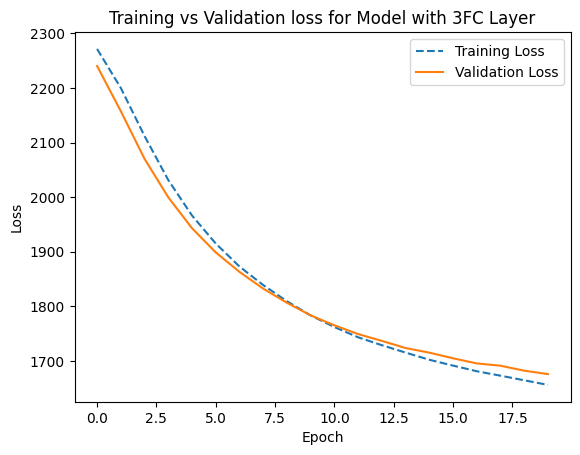

In [31]:
plt.title("Training vs Validation loss for Model with 3FC Layer")
plt.plot(loss_list[:,0], linestyle='--', label="Training Loss")
plt.plot(loss_list[:,1], linestyle='-', label="Validation Loss" )
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [32]:
test_output_3fc = classifier_3fc(test_images.view(-1,784))

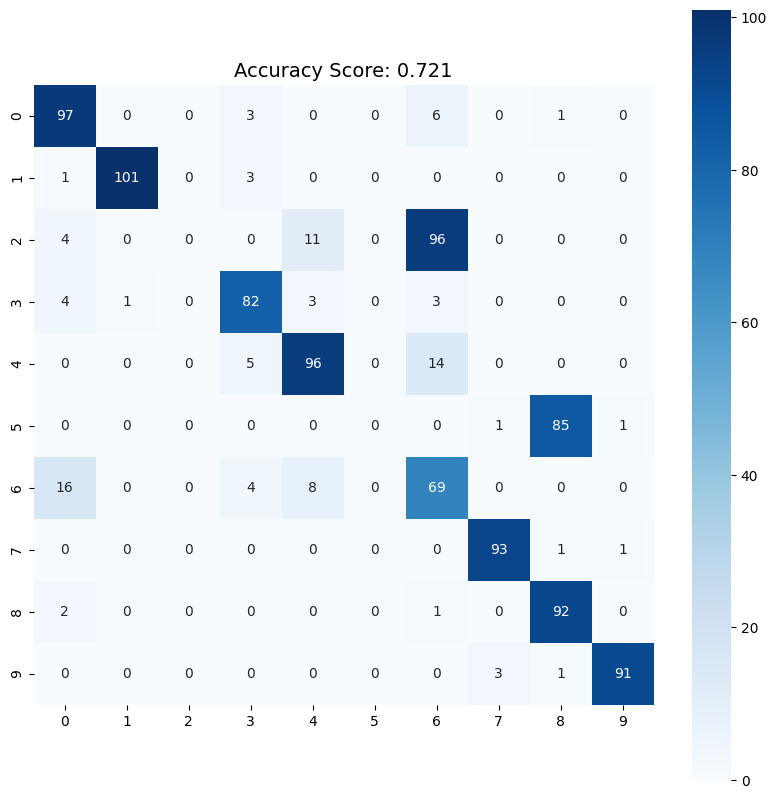

Overall Accuracy Score: 0.721
Classwise Accuracy Score: [0.90654206 0.96190476 0.         0.88172043 0.83478261 0.
 0.71134021 0.97894737 0.96842105 0.95789474]


In [33]:
with torch.no_grad():
    confusionMatrixAndAccuracyReport(test_labels,test_output_3fc.argmax(axis=1),testdataset.classes)

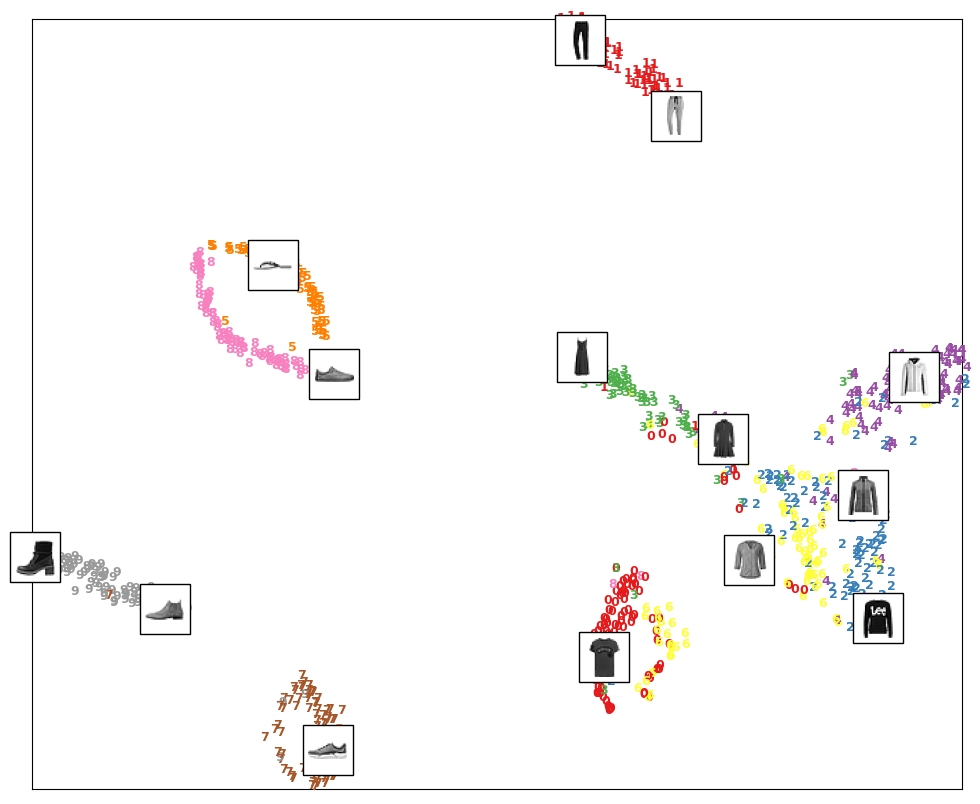

In [34]:
test_embed = model.encoder(test_images.view(-1,784))
with torch.no_grad():
    plot_embedding(test_embed,test_labels.numpy())

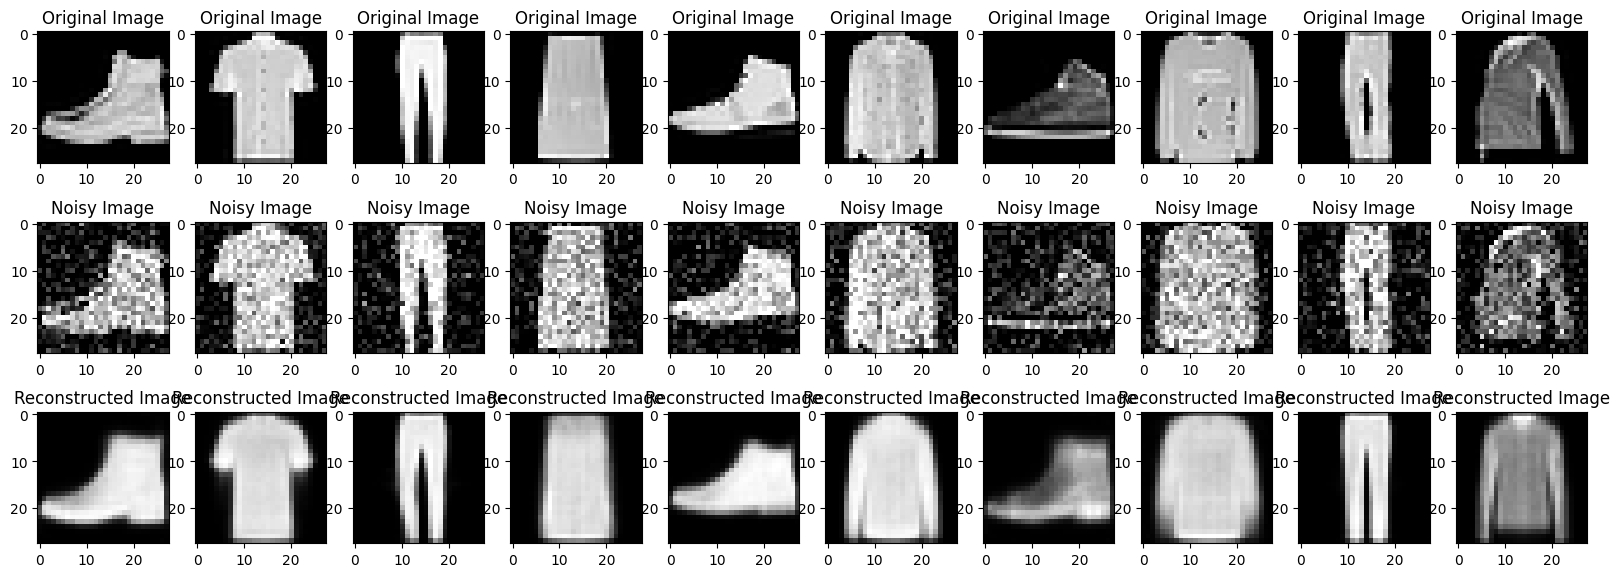

In [35]:
fig = plt.figure(figsize =(20,7))
nrows = 10
b=np.random.randint(0,test_images.shape[0]-nrows)
for i in range(nrows):
    plot = fig.add_subplot( 3,nrows, 0*nrows+i+1)
    plot.set_title('Original Image')
    imgplot = plt.imshow(test_images.view(-1, 28, 28)[b+i].cpu().detach(), cmap='gray')

    plot = fig.add_subplot( 3,nrows,  1*nrows+i+1)
    plot.set_title('Noisy Image')
    imgplot = plt.imshow(noisy_test_imgs.view(-1, 28, 28)[b+i].cpu().detach(), cmap='gray')

    plot = fig.add_subplot( 3,nrows,  2*nrows+i+1)
    plot.set_title('Reconstructed Image')
    imgplot = plt.imshow(test_output.view(-1, 28, 28)[b+i].cpu().detach(), cmap='gray')

plt.show()